In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.xkcd()
plt.rcParams['font.family'] = "xkcd"

In [3]:
from io import StringIO

def load_csv(path, names):
    lines = []
    with open(path, "r") as f:
        for line in f.readlines():
            if "OOM" in line:
                continue
            lines.append(line)
    df = pd.read_csv(
        StringIO("\n".join(lines)),
        header=None,
        names=names
    )
    return df

In [6]:
gpu_headers = []
for gpu in range(4):
    gpu_headers.append(f"Allocated MiB cuda{gpu}")
    gpu_headers.append(f"Reserved MiB cuda{gpu}")

data_headers = ['Batch size'] + gpu_headers + ['Iterations/second']

In [7]:
no_liger_df = load_csv(
    "./results-no-liger-4-gpu-limited-batch-sizes.csv",
    names=data_headers
)
no_liger_df.head()

,Batch size,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Iterations/second
0,1,37372,53276,0,0,0,0,0,0,1.418581
1,1,0,0,0,0,37354,52612,0,0,1.418579
2,1,0,0,37354,52532,0,0,0,0,1.418674
3,1,0,0,0,0,0,0,37354,52694,1.418619
4,8,0,0,46125,61050,0,0,0,0,0.640706


In [12]:
def validate_gpu_allocation(df):
    issues = []
    batch_sizes = df['Batch size'].unique()
    
    for batch_size in batch_sizes:
        group = df[df['Batch size'] == batch_size]
        
        if len(group) != 4:
            issues.append(f"Batch size {batch_size}: Expected 8 rows, but found {len(group)}")
            continue
        
        active_gpu_set = set()
        for i, row in group.iterrows():
            active_gpus = [(j, row[f'Allocated MiB cuda{j}']) for j in range(4) if row[f'Allocated MiB cuda{j}'] != 0]
            
            if len(active_gpus) != 1:
                issues.append(f"Batch size {batch_size}, Row {i}: Has {len(active_gpus)} active GPUs, expected 1")
            else:
                gpu_num = active_gpus[0][0]
                if gpu_num in active_gpu_set:
                    issues.append(f"Batch size {batch_size}: GPU {gpu_num} is active in multiple rows")
                active_gpu_set.add(gpu_num)
        
        if len(active_gpu_set) != 4:
            missing_gpus = set(range(8)) - active_gpu_set
            issues.append(f"Batch size {batch_size}: Missing data for GPUs {missing_gpus}")
    
    if not issues:
        print("All rows validated OK")
    else:
        print("Validation issues found:")
        for issue in issues:
            print(f"- {issue}")
    
    print(f"Total batch sizes checked: {len(batch_sizes)}")

In [13]:
validate_gpu_allocation(no_liger_df)

All rows validated OK
Total batch sizes checked: 3


In [14]:
def normalize_gpu_data(df):
    grouped = df.groupby('Batch size')
    
    normalized_data = []
    
    for batch_size, group in grouped:
        new_row = {'Batch size': batch_size}
        
        # Combine GPU data
        for gpu in range(4):
            allocated = group[f'Allocated MiB cuda{gpu}'].max()
            reserved = group[f'Reserved MiB cuda{gpu}'].max()
            new_row[f'Allocated MiB cuda{gpu}'] = allocated
            new_row[f'Reserved MiB cuda{gpu}'] = reserved
        
        # Average iterations/second
        new_row['Iterations/second'] = group['Iterations/second'].mean()
        
        normalized_data.append(new_row)
    
    # Create new DataFrame
    normalized_df = pd.DataFrame(normalized_data)
    
    # Ensure columns are in the same order as the original DataFrame
    normalized_df = normalized_df[df.columns]
    
    return normalized_df

In [15]:
no_liger_df = normalize_gpu_data(no_liger_df)
no_liger_df

,Batch size,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Iterations/second
0,1,37372,53276,37354,52532,37354,52612,37354,52694,1.418613
1,8,45901,61416,46125,61050,45901,61144,46237,62036,0.640708
2,16,54227,68624,54259,68674,54259,68642,54259,68576,0.346222


In [16]:
def add_gpu_summary_stats(df):
    # Calculate min, mean, and max for Allocated and Reserved MiB across all GPUs
    for metric in ['Allocated', 'Reserved']:
        # Get all columns for this metric
        cols = [col for col in df.columns if col.startswith(f'{metric} MiB cuda')]
        
        # Calculate min, mean, and max
        df[f'{metric} MiB Min'] = df[cols].min(axis=1)
        df[f'{metric} MiB Mean'] = df[cols].mean(axis=1)
        df[f'{metric} MiB Max'] = df[cols].max(axis=1)
    
    return df

In [17]:
no_liger_df = add_gpu_summary_stats(no_liger_df)
no_liger_df

,Batch size,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Iterations/second,Allocated MiB Min,Allocated MiB Mean,Allocated MiB Max,Reserved MiB Min,Reserved MiB Mean,Reserved MiB Max
0,1,37372,53276,37354,52532,37354,52612,37354,52694,1.418613,37354,37358.5,37372,52532,52778.5,53276
1,8,45901,61416,46125,61050,45901,61144,46237,62036,0.640708,45901,46041.0,46237,61050,61411.5,62036
2,16,54227,68624,54259,68674,54259,68642,54259,68576,0.346222,54227,54251.0,54259,68576,68629.0,68674


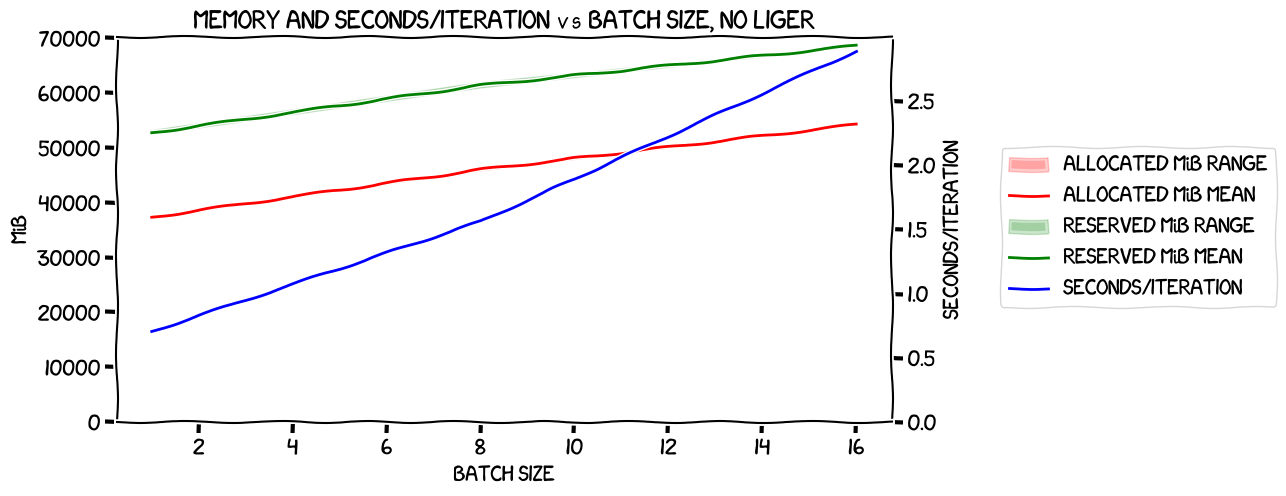

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.fill_between(no_liger_df['Batch size'], no_liger_df['Allocated MiB Min'], no_liger_df['Allocated MiB Max'], alpha=0.2, color='red', label='ALLOCATED MiB RANGE')
ax1.plot(no_liger_df['Batch size'], no_liger_df['Allocated MiB Mean'], label='ALLOCATED MiB MEAN', color='red', linewidth=2)
ax1.fill_between(no_liger_df['Batch size'], no_liger_df['Reserved MiB Min'], no_liger_df['Reserved MiB Max'], alpha=0.2, color='green', label='RESERVED MiB RANGE')
ax1.plot(no_liger_df['Batch size'], no_liger_df['Reserved MiB Mean'], label='RESERVED MiB MEAN', color='green', linewidth=2)
ax1.set_xlabel('BATCH SIZE')
ax1.set_ylabel('MiB')
ax1.tick_params(axis='y')
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.plot(no_liger_df['Batch size'], 1 / no_liger_df['Iterations/second'], label='SECONDS/ITERATION', color='blue')
ax2.set_ylabel('SECONDS/ITERATION')
ax2.tick_params(axis='y')
ax2.set_ylim(bottom=0)

plt.title('MEMORY AND SECONDS/ITERATION vs BATCH SIZE, NO LIGER')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("/tmp/memory-and-seconds-per-iteration-vs-batch-size-no-liger.png", bbox_inches='tight')
plt.show()

In [19]:
with_liger_df = load_csv(
    "./results-liger-4-gpu-limited-batch-sizes.csv",
    names=data_headers
)
with_liger_df.head()

,Batch size,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Iterations/second
0,1,0,0,0,0,0,0,38305,53360,1.280426
1,1,0,0,0,0,37395,53214,0,0,1.280420
2,1,37390,52524,0,0,0,0,0,0,1.280419
3,1,0,0,37435,53168,0,0,0,0,1.280371
4,8,0,0,0,0,0,0,43651,61016,0.643331


In [20]:
validate_gpu_allocation(with_liger_df)

All rows validated OK
Total batch sizes checked: 6


In [21]:
with_liger_df = normalize_gpu_data(with_liger_df)
with_liger_df

,Batch size,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Iterations/second
0,1,37390,52524,37435,53168,37395,53214,38305,53360,1.280409
1,8,43753,60456,43529,61232,43635,61080,43651,61016,0.643331
2,16,46078,64414,46078,64094,45886,64514,46078,63428,0.355816
3,32,49863,69786,49863,69442,49863,69288,49671,70084,0.188674
4,48,53584,74122,53584,73782,53584,73784,53360,74448,0.127492
5,64,57369,75222,57817,74696,57817,78240,57369,75080,0.096436


In [22]:
with_liger_df = add_gpu_summary_stats(with_liger_df)
with_liger_df

,Batch size,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Iterations/second,Allocated MiB Min,Allocated MiB Mean,Allocated MiB Max,Reserved MiB Min,Reserved MiB Mean,Reserved MiB Max
0,1,37390,52524,37435,53168,37395,53214,38305,53360,1.280409,37390,37631.25,38305,52524,53066.5,53360
1,8,43753,60456,43529,61232,43635,61080,43651,61016,0.643331,43529,43642.00,43753,60456,60946.0,61232
2,16,46078,64414,46078,64094,45886,64514,46078,63428,0.355816,45886,46030.00,46078,63428,64112.5,64514
3,32,49863,69786,49863,69442,49863,69288,49671,70084,0.188674,49671,49815.00,49863,69288,69650.0,70084
4,48,53584,74122,53584,73782,53584,73784,53360,74448,0.127492,53360,53528.00,53584,73782,74034.0,74448
5,64,57369,75222,57817,74696,57817,78240,57369,75080,0.096436,57369,57593.00,57817,74696,75809.5,78240


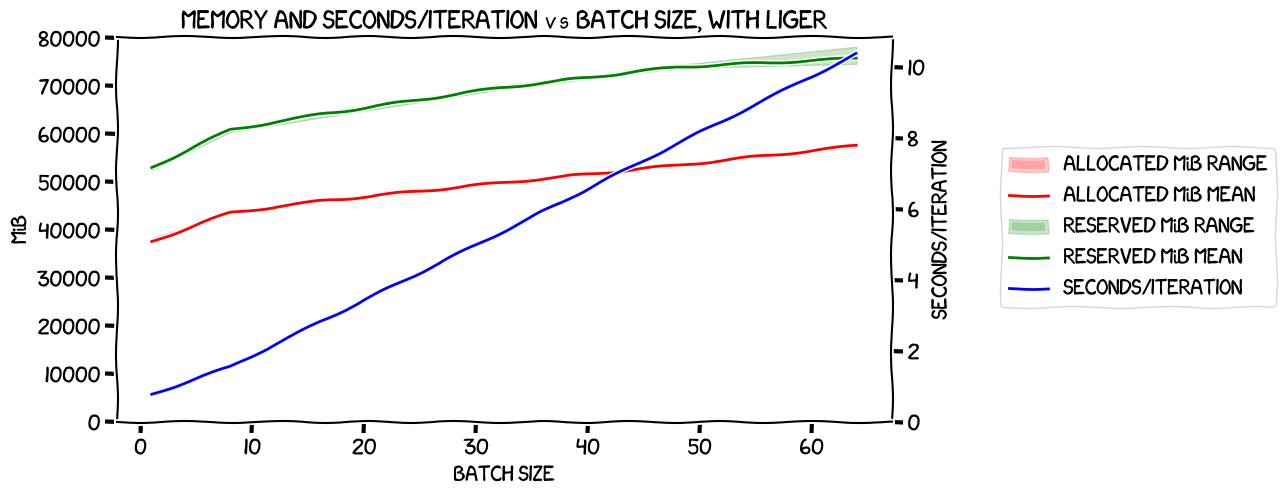

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.fill_between(with_liger_df['Batch size'], with_liger_df['Allocated MiB Min'], with_liger_df['Allocated MiB Max'], alpha=0.2, color='red', label='ALLOCATED MiB RANGE')
ax1.plot(with_liger_df['Batch size'], with_liger_df['Allocated MiB Mean'], label='ALLOCATED MiB MEAN', color='red', linewidth=2)
ax1.fill_between(with_liger_df['Batch size'], with_liger_df['Reserved MiB Min'], with_liger_df['Reserved MiB Max'], alpha=0.2, color='green', label='RESERVED MiB RANGE')
ax1.plot(with_liger_df['Batch size'], with_liger_df['Reserved MiB Mean'], label='RESERVED MiB MEAN', color='green', linewidth=2)
ax1.set_xlabel('BATCH SIZE')
ax1.set_ylabel('MiB')
ax1.tick_params(axis='y')
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.plot(with_liger_df['Batch size'], 1 / with_liger_df['Iterations/second'], label='SECONDS/ITERATION', color='blue')
ax2.set_ylabel('SECONDS/ITERATION')
ax2.tick_params(axis='y')
ax2.set_ylim(bottom=0)

plt.title('MEMORY AND SECONDS/ITERATION vs BATCH SIZE, WITH LIGER')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("/tmp/memory-and-seconds-per-iteration-vs-batch-size-with-liger.png", bbox_inches='tight')
plt.show()

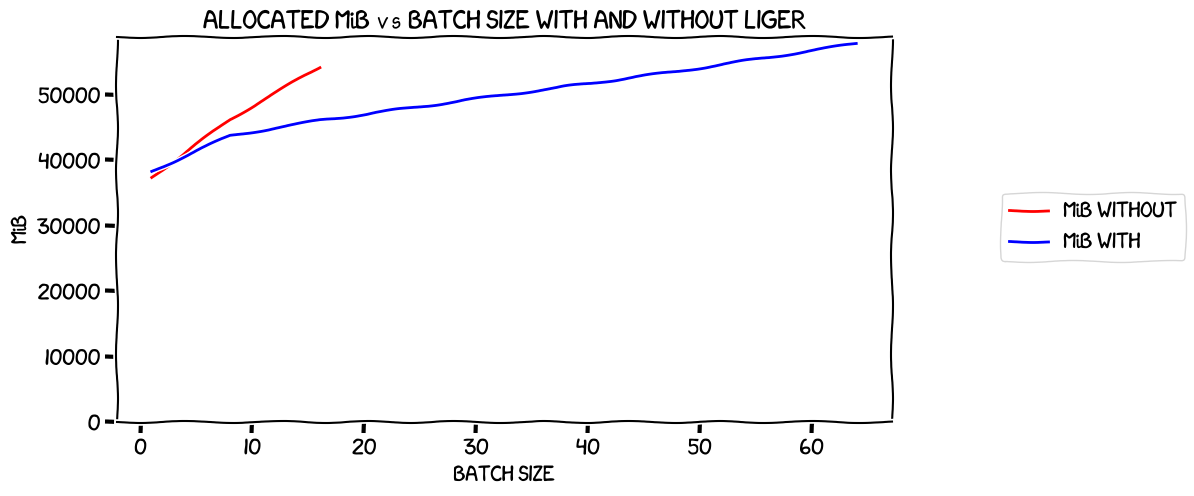

In [30]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(no_liger_df['Batch size'], no_liger_df['Allocated MiB Max'], label='MiB WITHOUT', color='red')
ax1.plot(with_liger_df['Batch size'], with_liger_df['Allocated MiB Max'], label='MiB WITH', color='blue')
ax1.set_xlabel('BATCH SIZE')
ax1.set_ylabel('MiB')
ax1.tick_params(axis='y')
ax1.set_ylim(bottom=0)

plt.title('ALLOCATED MiB vs BATCH SIZE WITH AND WITHOUT LIGER')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("/tmp/memory-vs-batch-size-with-and-without-liger.png", bbox_inches='tight')
plt.show()

In [26]:
github_benchmark_without = pd.DataFrame({
    'Batch size': [32, 48],
    'Allocated MiB Max': [55000, 67000]
})

In [27]:
github_benchmark_with = pd.DataFrame({
    'Batch size': [32, 48, 64],
    'Allocated MiB Max': [39000, 40500, 43000]
})

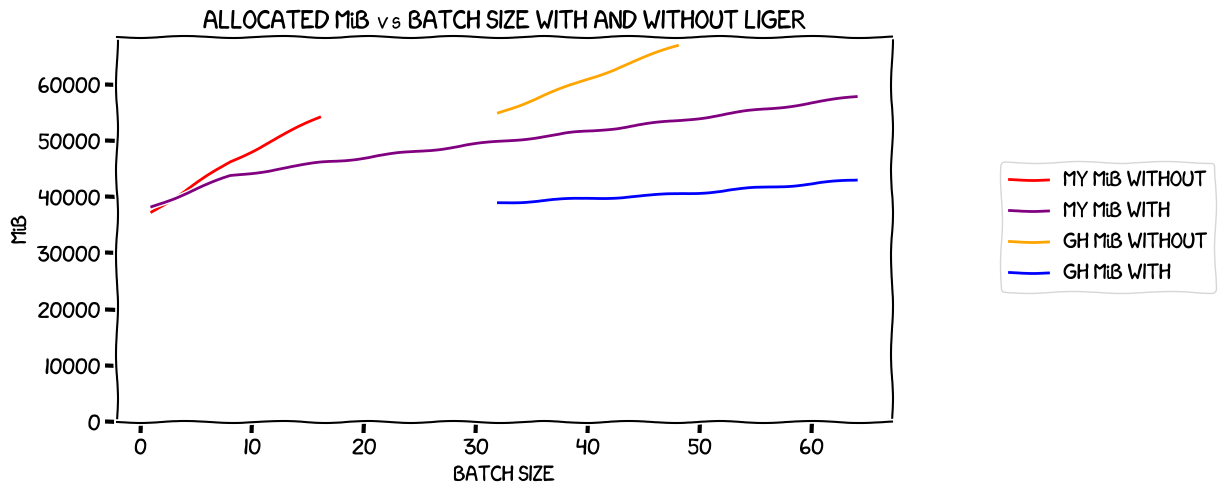

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(no_liger_df['Batch size'], no_liger_df['Allocated MiB Max'], label='MY MiB WITHOUT', color='red')
ax1.plot(with_liger_df['Batch size'], with_liger_df['Allocated MiB Max'], label='MY MiB WITH', color='purple')
ax1.plot(github_benchmark_without['Batch size'], github_benchmark_without['Allocated MiB Max'], label='GH MiB WITHOUT', color='orange')
ax1.plot(github_benchmark_with['Batch size'], github_benchmark_with['Allocated MiB Max'], label='GH MiB WITH', color='blue')
ax1.set_xlabel('BATCH SIZE')
ax1.set_ylabel('MiB')
ax1.tick_params(axis='y')
ax1.set_ylim(bottom=0)

plt.title('ALLOCATED MiB vs BATCH SIZE WITH AND WITHOUT LIGER')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("/tmp/memory-vs-batch-size-with-and-without-liger.png", bbox_inches='tight')
plt.show()